In [173]:
import numpy as np
import scipy as sc
from classifiers import Sigmoid_Regression
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Sigmoid Models with Logarithmic Loss

Consider the following protocol: for $t=1,2,...,T$, nature chooses $x_t \in \mathbb{R}^d$ in each round, and then reveals a noisy label $y_t \sim \text{Ber}(p(x_t^\top \theta^\star))$, where $\theta^\star \in \mathbb{R}^d$ is the unknown parameter and $p(z) = 1/(1 + e^{-x})$ is the link function. Our goal is to learn to make accurate predictions given a linear model class and any $x \in \mathbb{R}^d$, i.e., to predict $y^\star(x) = p(x^\top \theta^\star)$. One way of learning $\theta^\star$ given i.i.d samples of $\{x_t,y_t\}_{t=1}^T$ is to perform nonlinear least squares regression.

Nonlinear least sqaures regression considers the following estimator and prediction: given $\{x_t,y_t\}_{t=1}^T$ compute:

$$
\hat\theta_T := \arg\min_{\theta \in \mathbb{R}^d} \sum_{t=1}^T \left( p(x_t^\top \theta) - y_t\right)^2 
$$

and set $\hat y_T(x) := p(x^\top \hat\theta_T)$. The estimator and the prediciton can also be solved using a number of popular nonlinear least sqaures solver, such as the Gauss Newton Algorithm. In the below code, we scipy's built in nonlinear least sqaures solver $\href{https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html}{\texttt{scipy.optimize.least_squares}}$.

Another way of learning $\theta^\star$  given i.i.d samples of $\{x_t,y_t\}_{t=1}^T$ is to perform regression with the negative logarithmic (cross-entropy) loss. 

Regression with negative logarithmic loss considers the following estimator and prediciton: given $\{x_t,y_t\}_{t=1}^T$ compute:

$$
\hat\theta_T := \arg\max_{\theta \in \mathbb{R}^d} \mathcal{L}(\{x_t,y_t\}_{t=1}^T;\theta) = \arg\max_{\theta \in \mathbb{R}^d}  \sum_{t=1}^T y_t \log(p(x_t^\top \theta)) + (1-y_t)\log(1-p(x_t^\top \theta))
$$
and set $\hat y_T(x) := p(x^\top \hat\theta_T)$. The estimaotr and the prediciton cannot be solved in closed form, however the loss function defined above is concave in its argument. Therefore approximate solvers like Newtown's method or Gradient Descent, should be sufficient for finding the $\theta$ that minimizes the negative logarithmic loss. Taking the first derivative of the loss $\mathcal{L}$ we get:2*

$$
\frac{\partial}{\partial \theta}  \mathcal{L}(\{x_t,y_t\}_{t=1}^T;\theta) = g_T(\theta) :=  \sum_{t=1}^T (2 \cdot y_t - \tanh(x_t^\top \theta) - 1)x_t.
$$

Taking the second derivative of $\mathcal{L}$ gives:

$$
\frac{\partial^2}{\partial \theta^2}  \mathcal{L}(\{x_t,y_t\}_{t=1}^T;\theta)= H_T(\theta) :=  \sum_{t=1}^T -\frac{1}{2\cdot\cosh(x_t^\top\theta)} x_t x_t^\top.
$$

Thus we can solve:

$$
\hat\theta_T := \arg\min_{\theta \in \mathbb{R}^d} - \mathcal{L}(\{x_t,y_t\}_{t=1}^T;\theta)
$$

by applying Newton's method for $k=1,2,...,n$, i.e.

$$
\theta_{k+1} = \theta_k - \left(H_T^{-1}(\theta_k)\right)^\top g_t(\theta_k).
$$

where $\theta_0$ is initialized approprioately, i.e. $\theta_0 \sim \mathcal{N}(0,I)$. Setting $\hat\theta_T = \theta_n$ gives us our estimator and letting $\hat y_T(x) = p(x^\top \hat\theta_T)$ gives us our predictor. 

In [207]:
np.save('features.npy',features)
np.save('tar.npy',tar)
np.save('theta_star.npy',theta_star)

In [238]:
d = 20
num_features = 50
theta_star = np.random.uniform(low=0.5,high=1.5,size=d) 
theta_star[-1] = 10

num_samples = 550000
features = np.zeros((num_samples,d))
tar = np.zeros(num_samples)
reg = Sigmoid_Regression(features[:d],tar[:d],d,50,theta_star)
X = np.random.uniform(low=-0.2,high=1.0,size=(num_features,d)) 
for i in tqdm(range(num_samples)):
    j = i % num_features
    feature = X[j]
    mean = reg.p(np.inner(X[j],theta_star))
    obs = np.random.binomial(1,p=mean) 
    features[i] = feature
    tar[i] = obs

  0%|          | 0/500000 [00:00<?, ?it/s]

In [272]:
num_arms = 5
num_eval = 1000
trials = 30
data = [500, 1000, 5000, 10000, 50000, 250000]
n = len(data)
loss_opt_vec = np.zeros(n)
loss_log_vec = np.zeros(n)
loss_ls_vec = np.zeros(n)
k = 0
for dat in data:
    num_data = dat
    reg = Sigmoid_Regression(features[:num_data],tar[:num_data],d,50000,theta_star)
    theta_log = reg.solve_Logit_Regression()
    reg.solve_LS()
    for j in tqdm(range(trials)):
        loss_opt=0
        loss_log=0
        loss_ls=0
        for i in (range(num_eval)):
            X = np.random.uniform(low=-1.9,high=3.0,size=(num_features,d))
            X[0,-1] = -1.0
            
            arm_opt = np.argmin(reg.p(np.dot(X,theta_star)))
            L = np.random.binomial(1,p=reg.p(np.inner(X[arm_opt],theta_star)))
            loss_opt += L

            arm_log = np.argmin(reg.p(np.dot(X,theta_log.T)))
            L = np.random.binomial(1,p=reg.p(np.inner(X[arm_log],theta_star)))
            loss_log += L

            arm_ls = np.argmin(reg.p(np.dot(X,reg.theta_ls)))
            L = np.random.binomial(1,p=reg.p(np.inner(X[arm_ls],theta_star)))
            loss_ls += L
        loss_opt_vec[k] += loss_opt
        loss_log_vec[k] += loss_log
        loss_ls_vec[k] += loss_ls
    k+=1

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [277]:
loss_opt_vec/trials

array([0.23333333, 0.13333333, 0.23333333, 0.1       , 0.23333333,
       0.23333333])

In [278]:
loss_log_vec/trials

array([331.73333333, 327.73333333, 148.53333333, 146.23333333,
       105.7       ,  21.56666667])

In [279]:
loss_ls_vec/trials

array([518.6       , 579.86666667, 266.43333333, 282.9       ,
       304.13333333,  41.16666667])

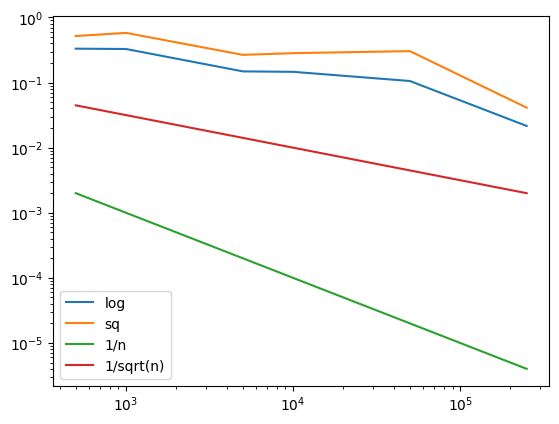

In [280]:
plt.loglog(data, loss_log_vec/(trials*num_eval),label='log')

plt.loglog(data, loss_ls_vec/(trials*num_eval),label='sq')
plt.loglog(data, 1 / np.array(data),label='1/n')
plt.loglog(data, 1 / np.sqrt(np.array(data)),label='1/sqrt(n)')
plt.legend()
plt.show()

In [249]:
tar

array([1., 1., 1., ..., 1., 1., 1.])